In [1]:
# Copyright 2018 Esref Ozdemir
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Try Clustering Features
In this notebook, we compute various clustering features and see if they can potentially be used to predict events of interest.

In [1]:
%matplotlib inline
from collections import namedtuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

from utils import inner_dist, remove_missing_raw_rows

## 1. Finding Degree of Clustering
Need to find a way to assess the degree of clustering (especially clustering around the penalty area). Using kmeans might be a way.

Need to find features that can describe clustering of players better than simply summing inner distances. innerDistanceSum cannot distinguish between the cases where

1. some players are clustered when there are outliers,
2. all players are fairly apart from each other

with both cases leading to average to high distance sum.

In [7]:
KMeansResult = namedtuple('KMeansResult', 'count max_dist_to_centroid density')


def kmeans_results(points):
    n_clusters = 2
    
    kmeans = KMeans(n_clusters=n_clusters, n_init=10)
    kmeans = kmeans.fit(points)
    centroids = kmeans.cluster_centers_
    
    accum = []
    
    for i in range(n_clusters):
        cluster = points[kmeans.labels_ == i]
        num_points = len(cluster)
        diff = (cluster - centroids[i])**2
        max_dist = np.max(np.sum(diff, axis=1))
        different_players = not np.isclose(max_dist, 0)
        density = num_points/max_dist if different_players else 0
        accum.append((cluster, i, KMeansResult(num_points, max_dist, density)))
                     
    return accum

In [4]:
mid = 20157
event = pd.read_csv('../data/train_events/{}_event.csv'.format(mid))
raw = pd.read_csv('../data/processed/{}_raw.csv'.format(mid))

In [5]:
event[event['eventId'] == 80].head()

,teamId,eventId,jersey,half,minute,second,location,bodyPart,postLocation,custom
751,2,80,10,1,44,39,1,3,3,0
1219,2,80,10,2,77,59,1,2,4,2


KMeansResult(count=10, max_dist_to_centroid=839.78755980201049, density=0.011907773440175292)
KMeansResult(count=10, max_dist_to_centroid=226.50946057999766, density=0.04414826636553771)


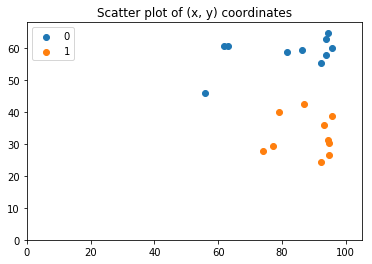

In [8]:
sec = raw[(raw['half'] == 2) & (raw['minute'] == 50) & (raw['second'] == 14)]
team_mask = (sec['teamType'] == 1) | (sec['teamType'] == 2)
sec = sec[team_mask]
points = sec[['x', 'y']].values

for cluster, i, result in kmeans_results(points):
    plt.scatter(*cluster.T, label=i)
    print(result)
    
plt.xlim([0, 105])
plt.ylim([0, 68])
plt.title('Scatter plot of (x, y) coordinates')
plt.legend();

## 2. Finding Degree of Local Linearity
May be useful for penalty, freekick.

1. Players are linear in $y$ axis. Thus, if we only cluster the players along the $x$ axis, we might find linear structures along $y$.

In [9]:
def vertical_clustering(points):
    n_clusters = 4
    x = points[:, 0].reshape(-1, 1)
    
    kmeans = KMeans(n_clusters=n_clusters, n_init=10)
    kmeans = kmeans.fit(x)
    centroids = kmeans.cluster_centers_
    
    accum = []
    
    for i in range(n_clusters):
        cluster_x = x[kmeans.labels_ == i]
        cluster_points = points[kmeans.labels_ == i]
        num_points = len(cluster_x)
        vert_diff = x - centroids[i]
        max_dist = np.max(vert_diff)
        different_players = not np.isclose(max_dist, 0)
        density = num_points/max_dist if different_players else 0
        accum.append((cluster_points, i, KMeansResult(num_points, max_dist, density)))
                     
    return accum

KMeansResult(count=5, max_dist_to_centroid=25.714466666666802, density=0.19444307614131504)
KMeansResult(count=6, max_dist_to_centroid=2.3039555555556461, density=2.6042169023321184)
KMeansResult(count=4, max_dist_to_centroid=11.943116666666768, density=0.33492095167788133)
KMeansResult(count=5, max_dist_to_centroid=35.775826666666845, density=0.13975917444441932)


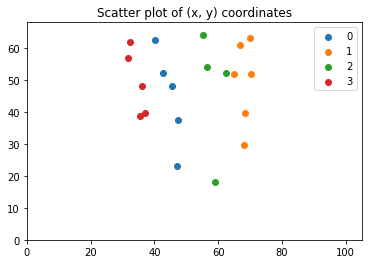

In [10]:
sec = raw[(raw['half'] == 2) & (raw['minute'] == 63) & (raw['second'] == 24)]
team_mask = (sec['teamType'] == 1) | (sec['teamType'] == 2)
sec = sec[team_mask]
points = sec[['x', 'y']].values

for cluster, i, result in vertical_clustering(points):
    plt.scatter(*cluster.T, label=i)
    print(result)
    
plt.xlim([0, 105])
plt.ylim([0, 68])
plt.title('Scatter plot of (x, y) coordinates')
plt.legend();

## 3. Mixed/Separated Opposite Team Players
May be useful for distinguishing between penalty and goal events.

* In-cluster gini impurity.
  * How many clusters?
  * density $\times$ impurity?

In [11]:
from utils import gini_impurity


KMeansResult = namedtuple('KMeansResult', 'count density mixing_coeff')


def player_mixing(points, teamType):
    n_clusters = 4
    
    kmeans = KMeans(n_clusters=n_clusters, n_init=10)
    kmeans = kmeans.fit(points)
    centroids = kmeans.cluster_centers_
    
    accum = []
    
    for i in range(n_clusters):
        cluster = points[kmeans.labels_ == i]
        team = teamType[kmeans.labels_ == i]
        
        num_points = len(cluster)
        diff = (cluster - centroids[i])**2
        max_dist = np.max(np.sum(diff, axis=1))
        different_players = not np.isclose(max_dist, 0)
        density = num_points/max_dist if different_players else 0
        
        gini = gini_impurity(team)
        accum.append((cluster, i, KMeansResult(num_points, density, gini)))
                     
    return accum

In [59]:
def plot_impurity(half, minute, second):
    sec = raw[(raw['half'] == half) & (raw['minute'] == minute) & (raw['second'] == second)]
    team_mask = (sec['teamType'] == 1) | (sec['teamType'] == 2)
    sec = sec[team_mask]
    points = sec[['x', 'y']].values
    teamType = sec['teamType']

    plt.figure(figsize=(2*5*105/68, 5))
    plt.subplot(1, 2, 1)
    for cluster, i, result in player_mixing(points, teamType):
        plt.scatter(*cluster.T, label=i)
        print(result)

    plt.xlim([0, 105])
    plt.ylim([0, 68])
    plt.title('Found clusters')
    plt.legend();

    home = sec[teamType == 1]
    away = sec[teamType == 2]


    plt.subplot(1, 2, 2)
    plt.scatter(*home[['x', 'y']].values.T, label='Home')
    plt.scatter(*away[['x', 'y']].values.T, label='Away')
    plt.title('Players')
    plt.tight_layout()
    plt.legend();
    plt.xlim([0, 105])
    plt.ylim([0, 68])

### Goal Moment

KMeansResult(count=7, density=0.03554373840868582, mixing_coeff=0.24489795918367352)
KMeansResult(count=6, density=0, mixing_coeff=0.5)
KMeansResult(count=6, density=0.071774683551844479, mixing_coeff=0.0)
KMeansResult(count=1, density=0, mixing_coeff=0.0)


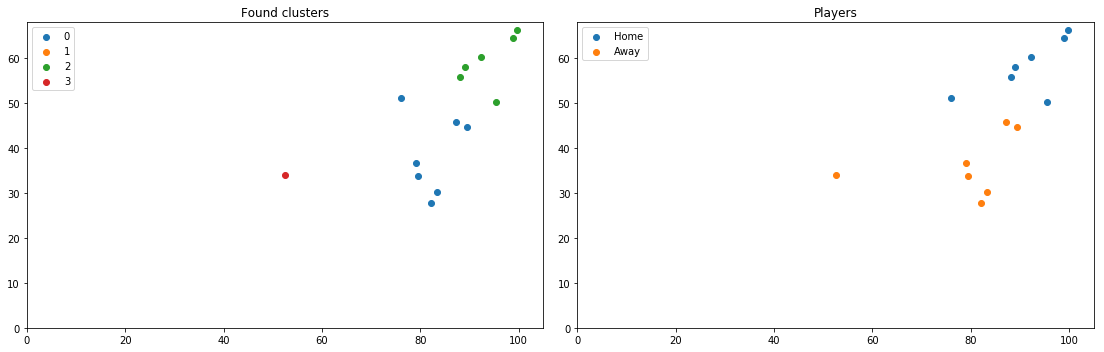

In [61]:
plot_impurity(2, 78, 10)

### No Event

KMeansResult(count=7, density=0.067592266189307318, mixing_coeff=0.48979591836734693)
KMeansResult(count=3, density=0.017698744793287379, mixing_coeff=0.44444444444444448)
KMeansResult(count=4, density=0.047021009662161085, mixing_coeff=0.5)
KMeansResult(count=6, density=0.14661974809386244, mixing_coeff=0.44444444444444448)


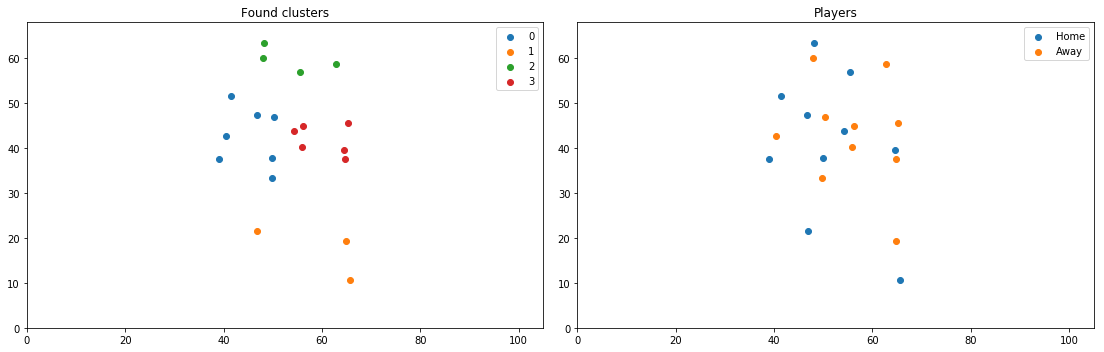

In [60]:
plot_impurity(2, 60, 30)